In [7]:
 #12 de Marzo de 2019

#Required packages

library(devtools)
library(BiocManager)
#BiocManager::install("pcaMethods", version= "3.8")
#devtools::install_github('kimsche/MetaboMate', build_vignettes=TRUE)
library(MetaboMate)
#devtools::install_github('jwist/visualizeR')
library(car)
library(RCurl)

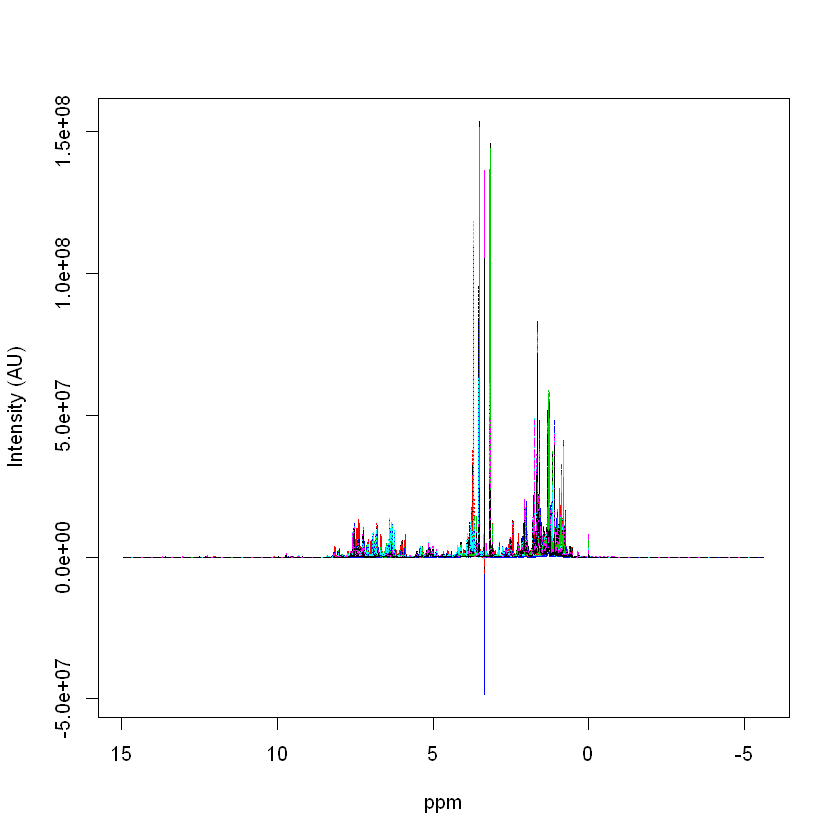

In [8]:
#Importing data to Metabomate (Row x Col)

setwd("C:/Users/ASUS/Documents/Propoleo_processed/Metabomate/Data")

Intensity <- rev(read.csv("noesypro_all_center.csv", header= FALSE, sep= ","))
Metadata <-read.csv("Propoleo_metadata.csv", header= TRUE, sep= ";")
ppm <- read.csv("ppmpro_all_center.csv", header= FALSE)

a_intensity <- t(Intensity)
ppm <- t(ppm)

#Bad shimming 
X <- a_intensity[c(-22, -25, -33, -36, -104, -112, -113, -119),]#Eliminar espectros con shims malos
Metadata_f <- Metadata[c(-22, -25, -33, -36, -104, -112, -113, -119),]#Eliminar espectros con shims malos]
ColorRGB <- data.frame(Metadata_f$SampleNMR, Metadata_f$R, Metadata_f$G, Metadata_f$B)

matspec(ppm, X, shift= range(ppm))

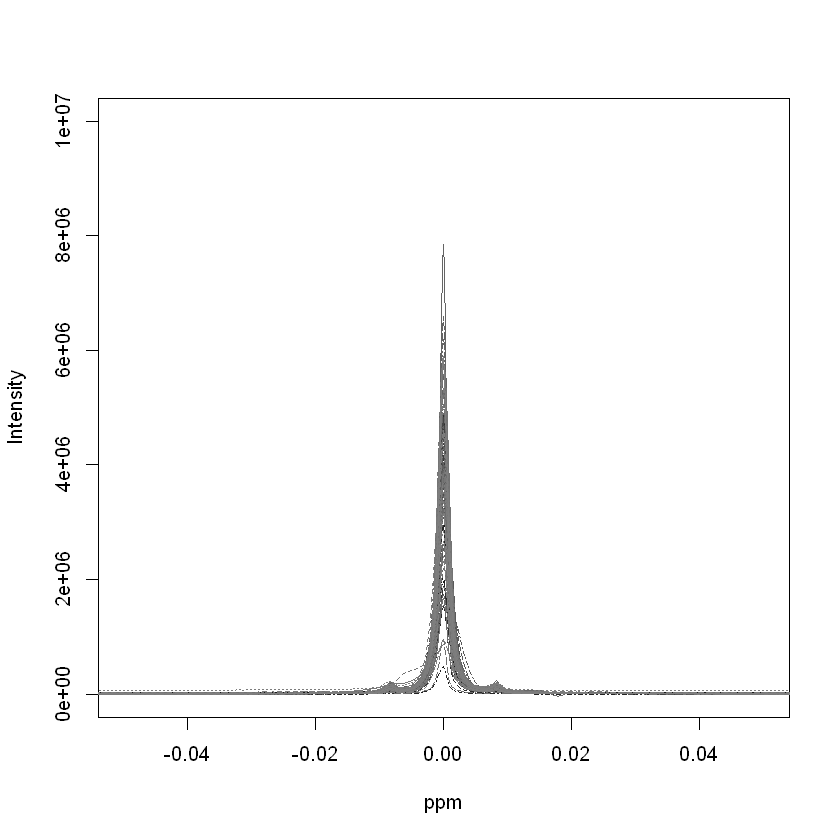

In [9]:
#Spectra Calibration
X.cali=calibration(X, ppm, type='Urine')

#Visualization
Gray <- gray.colors(115, start=0.1, end=0.5, gamma=2.2, alpha=NULL)

matplot(t(ppm),t(X.cali), type=("l"), xlim = c(-0.05,0.05), ylim=c(-1e4, 1e7), xlab="ppm", ylab="Intensity", col=Gray)


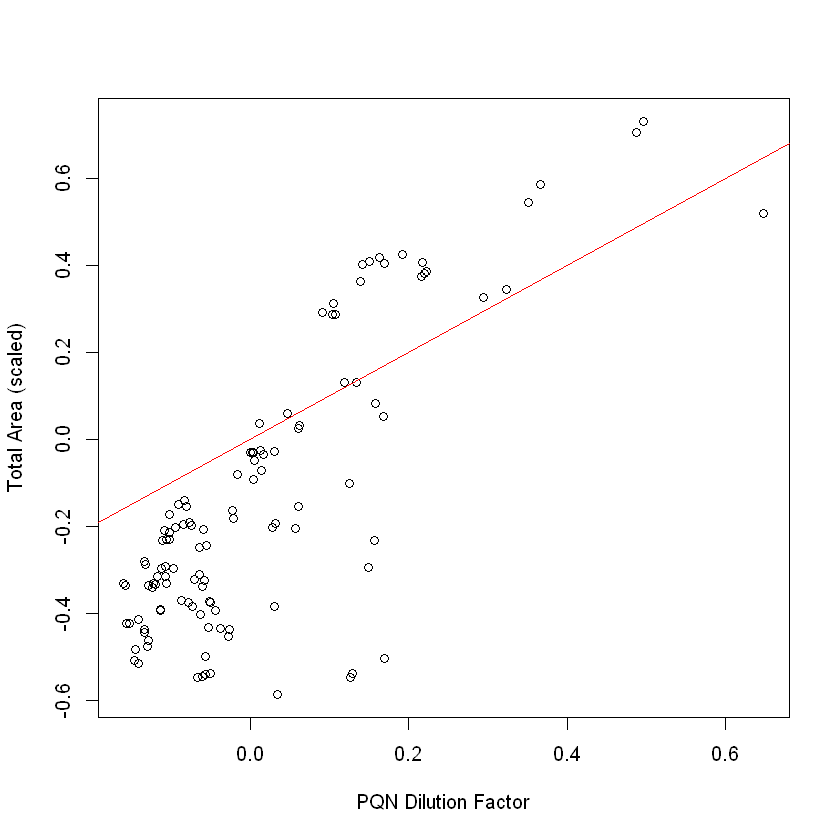

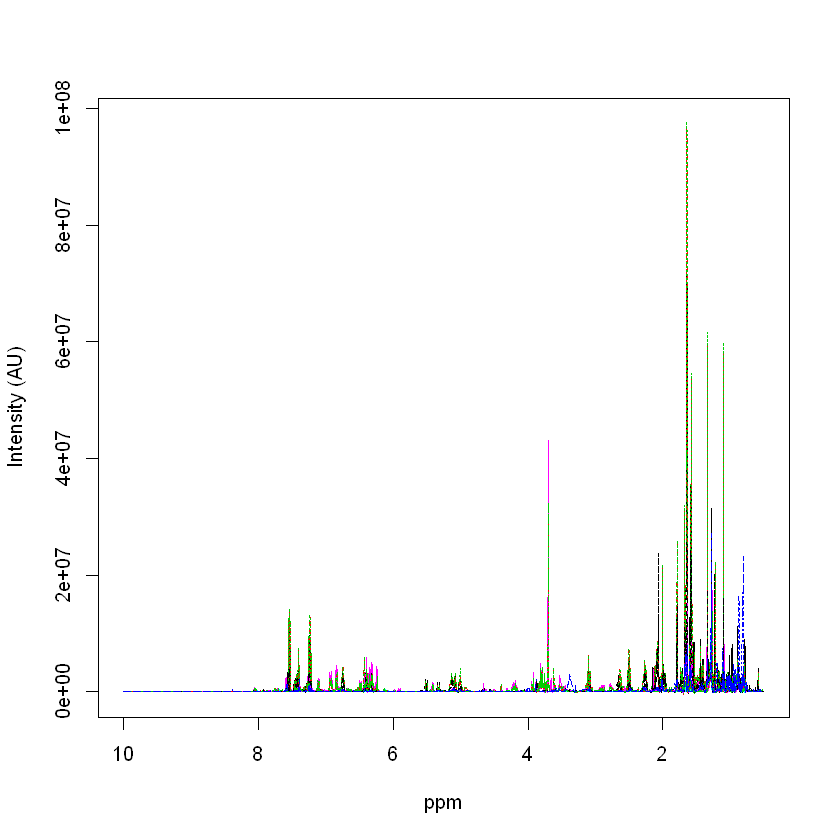

In [10]:
#Indexing of chemical shifts regions

idx.TMS= get.idx(range=c(min(ppm),0.5), ppm)
idx.meoh1= get.idx(range=c(3.15,3.29), ppm)
idx.meoh2= get.idx(range=c(3.32,3.38), ppm)
idx.meoh3= get.idx(range=c(3.51,3.54), ppm)
idx.water= get.idx(range=c(4.84,4.94), ppm)
idx.noise= get.idx(range=c(14,max(ppm)), ppm)

#Excision of undesired regions

X.cali=X.cali[,-c(idx.TMS, idx.meoh1, idx.meoh2, idx.meoh3, idx.water, idx.noise)]
ppm.ex=ppm[-c(idx.TMS, idx.meoh1, idx.meoh2, idx.meoh3, idx.water, idx.noise)]

#path="C:/Bruker/TopSpin4.0.3/examdata/Propoleo/"
#readBruker(path)

#Baseline correction

X.bl=bline(X.cali)

#Spectral normalisation

X.pqn= pqn(X.bl, add.DilF = 'dilF.pqn')
X.ta= totalArea(X.bl, add.DilF = 'dilF.ta')

plot(log10(dilF.pqn), log10(dilF.ta), xlab='PQN Dilution Factor', ylab='Total Area (scaled)')
abline(a = c(0,1), col='red')

#Visualisation

matspec(ppm.ex, X.pqn[1:10,], shift = c(0,10))


# PCA 

In [12]:
ID= Metadata_f$SampleID

pca.model=pca(X=X.pqn, pc=2, scale='UV', center=TRUE)



iterations: 19
iterations: 49
[1] 115   2
[1] 83970     2


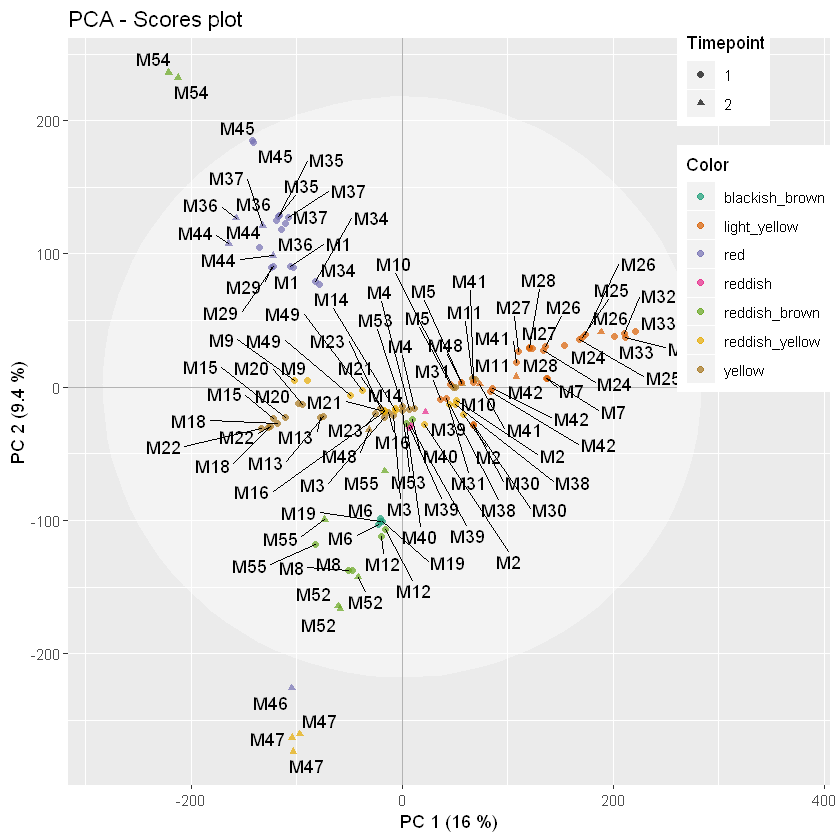

In [13]:
#Color classification and sample ID
plotscores(model=pca.model, pc=c(1,2), an=list(Color=Metadata_f$Color,Timepoint=as.character(Metadata_f$Probe),ID=ID), title='PCA - Scores plot')




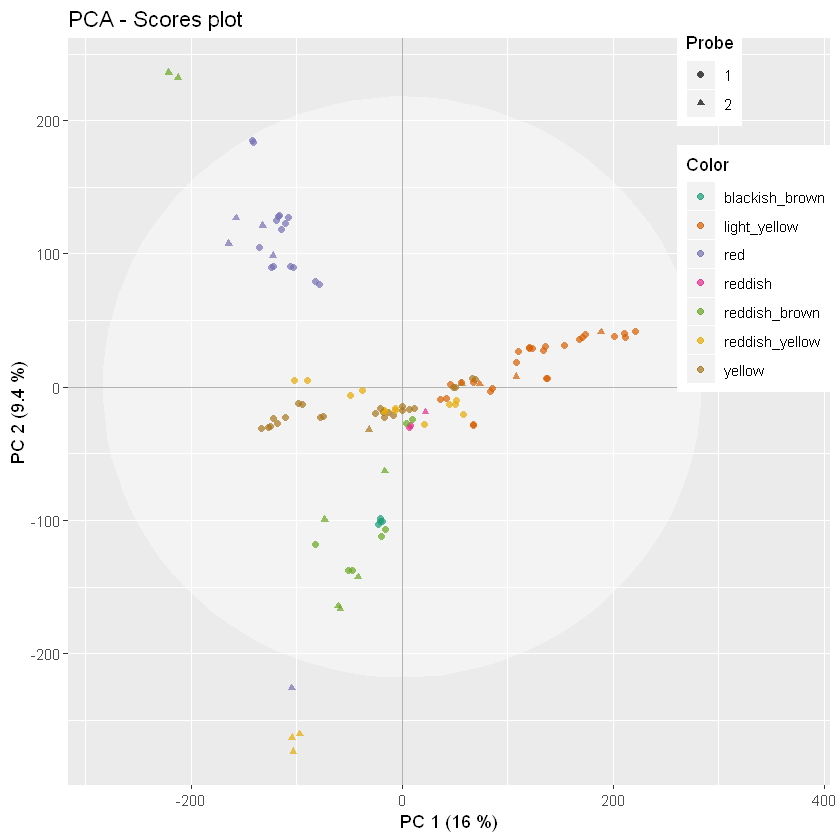

In [14]:
# Color classification

plotscores(model=pca.model, pc=c(1,2), an=list(Color=Metadata_f$Color,Probe=as.character(Metadata_f$Probe)), title='PCA - Scores plot')



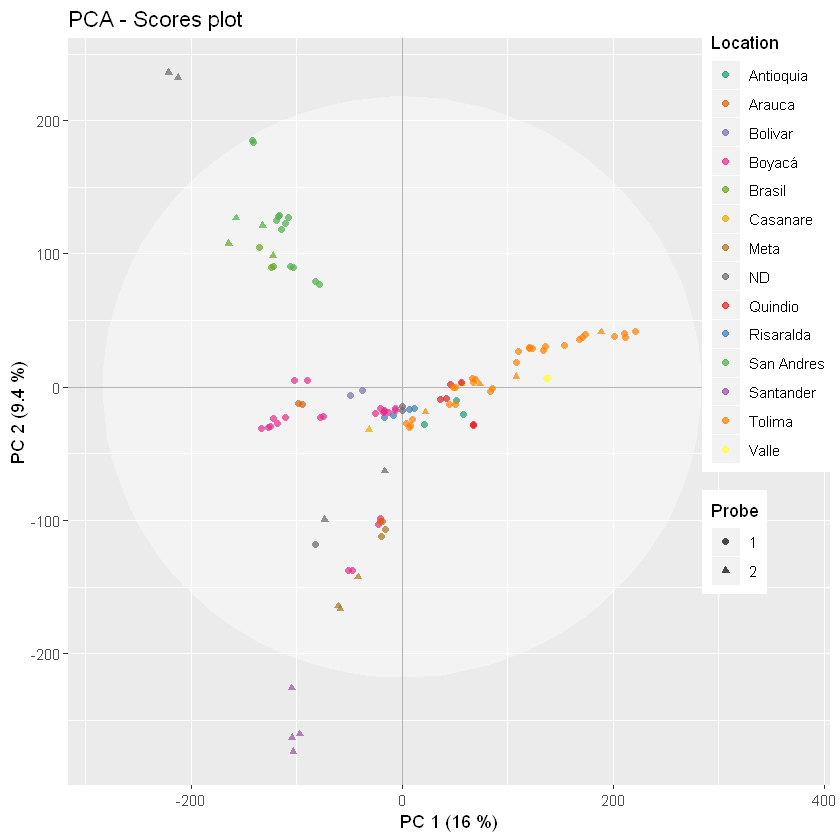

In [15]:
#location
plotscores(model=pca.model, pc=c(1,2), an=list(Location=Metadata_f$Origen,Probe=as.character(Metadata_f$Probe)), title='PCA - Scores plot')



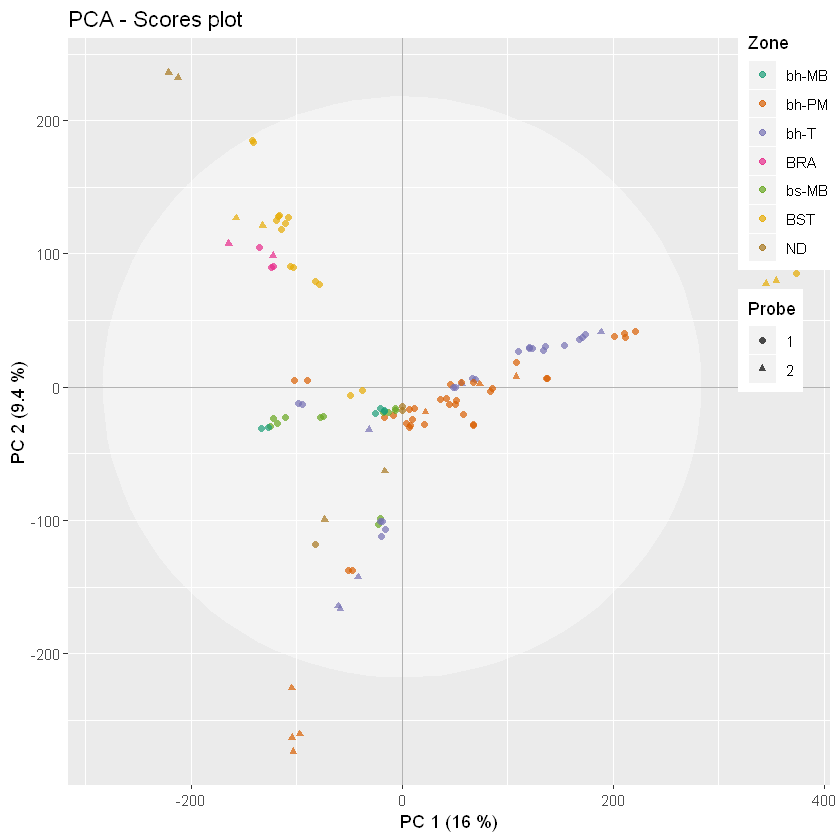

In [16]:
#Biogeographical region
plotscores(model=pca.model, pc=c(1,2), an=list(Zone=Metadata_f$Zona,Probe=as.character(Metadata_f$Probe)), title='PCA - Scores plot')



Warning message in if (grepl("stat|recon", type, ignore.case = T)) {:
"la condición tiene longitud > 1 y sólo el primer elemento será usado"

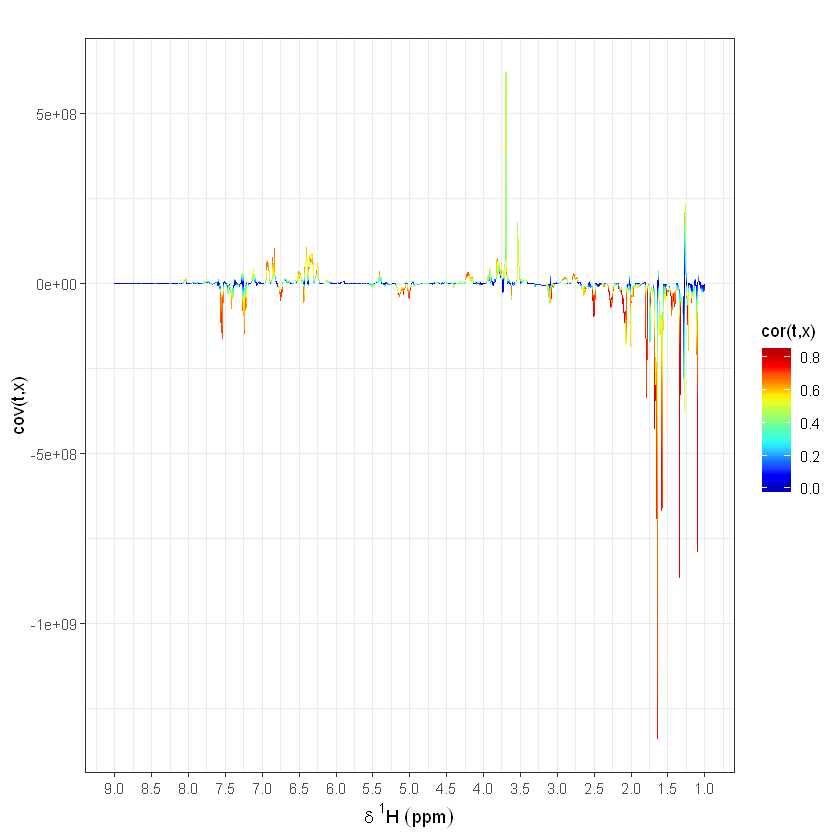

In [17]:
plotload(pca.model, X.pqn, ppm.ex, pc=2, shift=c(1,9))

# OPLS-DA

## Red propolis vs other propolis

In [18]:
###OPLS con Metabomate

Origen=as.character(Metadata_f$Type2)
propoleo.oplsmet<- opls(X.pqn,Origen,t_pred = 1)

###OPLS con ropls

library(ropls)

propoleo.opls <- opls(X.pqn,Origen,predI=1,orthoI=NA)

#Training
propoleo.opls1 <- opls(X.pqn,Origen,predI=1,orthoI=NA, subset="odd")

#Predictions on the training subset

trainVi <- getSubsetVi(propoleo.opls1)
table(Origen[trainVi], fitted(propoleo.opls1))

#Predictions on the test subset

table(Origen[-trainVi],
      predict(propoleo.opls1, X.pqn[-trainVi, ]))



Preparing data ... done.
Performing OPLS-DA ... [1] 0
At first PC, Q2 < 0.03: 0.822
At first PC, Q2 < 0.03: 0.981
[1] "No sign. orthogonal components!"


Warning message:
"package 'ropls' was built under R version 3.5.2"
Attaching package: 'ropls'

The following object is masked from 'package:MetaboMate':

    opls



OPLS-DA
115 samples x 83970 variables and 1 response
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum)  RMSEE pre ort pR2Y  pQ2
Total    0.375    0.996   0.975 0.0247   1   4 0.05 0.05


Warning message:
"'permI' set to 0 because train/test partition is selected"

OPLS-DA
58 samples x 83970 variables and 1 response
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum)  RMSEE  RMSEP pre ort
Total    0.399    0.997   0.821 0.0207 0.0431   1   4


   
     1  2
  1 10  0
  2  0 48

   
     1  2
  1  9  0
  2  0 48

## Red Colombian propolis vs red Brazilian propolis

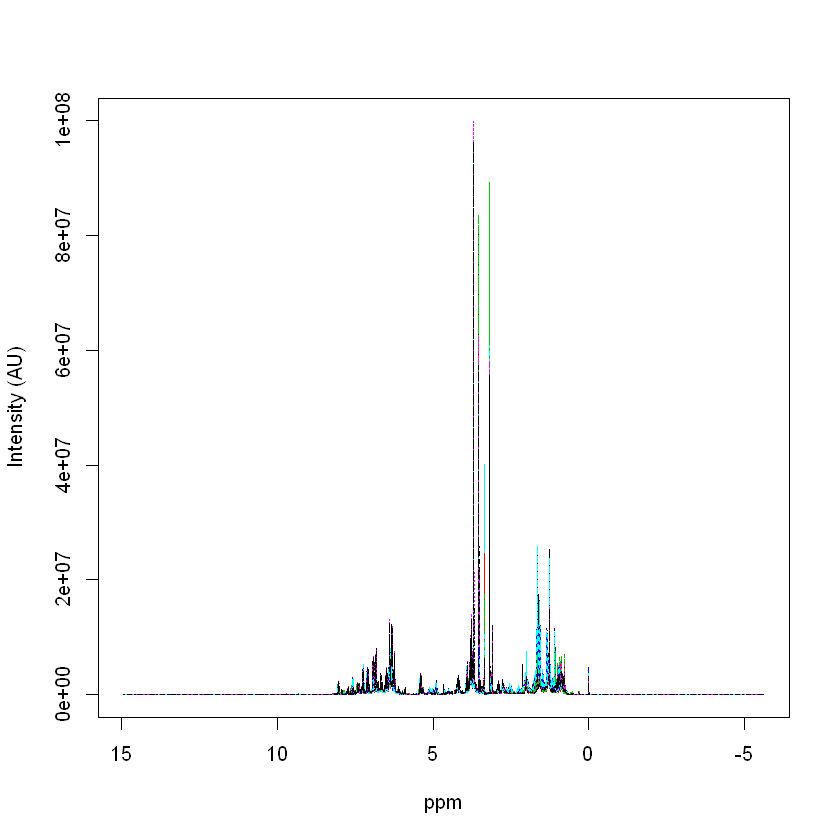

In [20]:
red_propolis <- subset(X, Metadata_f$Color=="red")

red_propolis <- red_propolis[c(-1),]

Metadata_red <- subset(Metadata_f, Metadata_f$Color=="red")

Metadata_red <- Metadata_red[c(-1),]

matspec(ppm, red_propolis, shift= range(ppm))



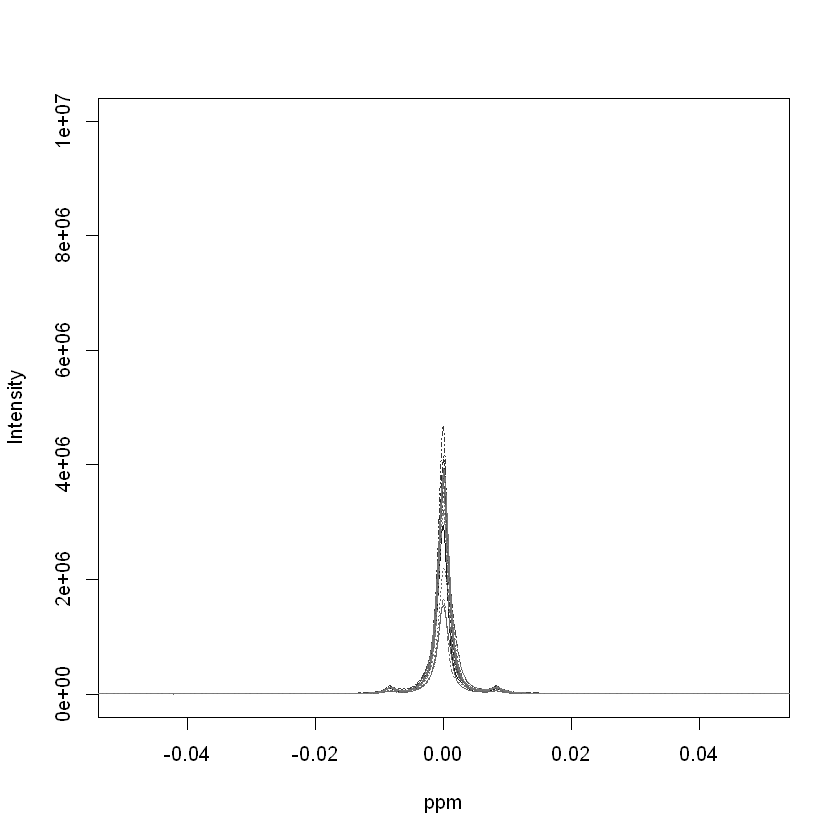

In [21]:
#Calibration
red_propolis.cali = calibration(red_propolis, ppm, type='Urine')

Gray <- gray.colors(20, start=0.1, end=0.5, gamma=2.2, alpha=NULL)

matplot(t(ppm),t(red_propolis.cali), type=("l"), xlim = c(-0.05,0.05), ylim=c(-1e4, 1e7), xlab="ppm", ylab="Intensity", col=Gray)

red_propolis.cali=red_propolis.cali[,-c(idx.TMS, idx.meoh1, idx.meoh2, idx.meoh3, idx.water, idx.noise)]



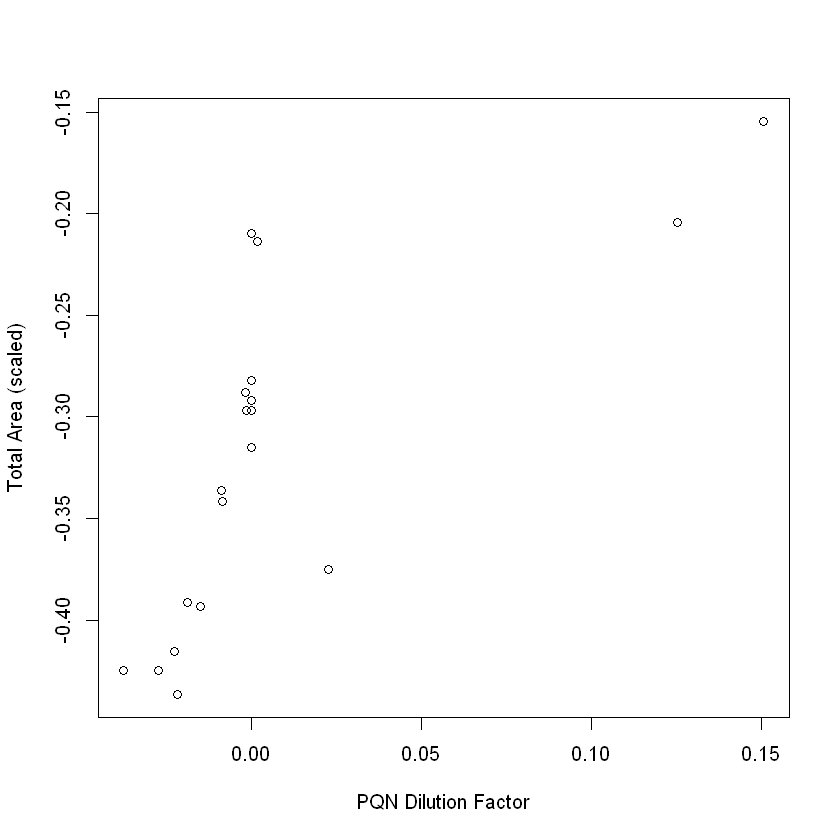

In [22]:
#Baseline correction

red_propolis.bl=bline(red_propolis.cali)

#Spectral normalisation

red_propolis.pqn= pqn(red_propolis.bl, add.DilF = 'dilF.pqn')
red_propolis.ta= totalArea(red_propolis.bl, add.DilF = 'dilF.ta')

plot(log10(dilF.pqn), log10(dilF.ta), xlab='PQN Dilution Factor', ylab='Total Area (scaled)')
abline(a = c(0,1), col='red')



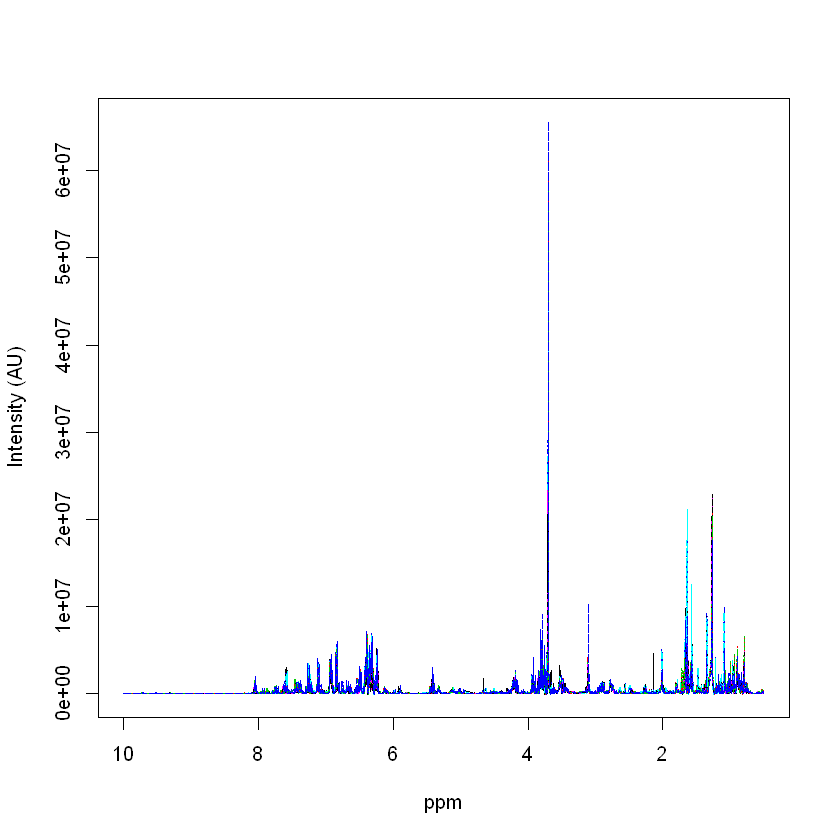

In [23]:
#Visualisation

matspec(ppm.ex, red_propolis.pqn[1:10,], shift = c(0,10))



iterations: 43
iterations: 19
[1] 19  2
[1] 83970     2


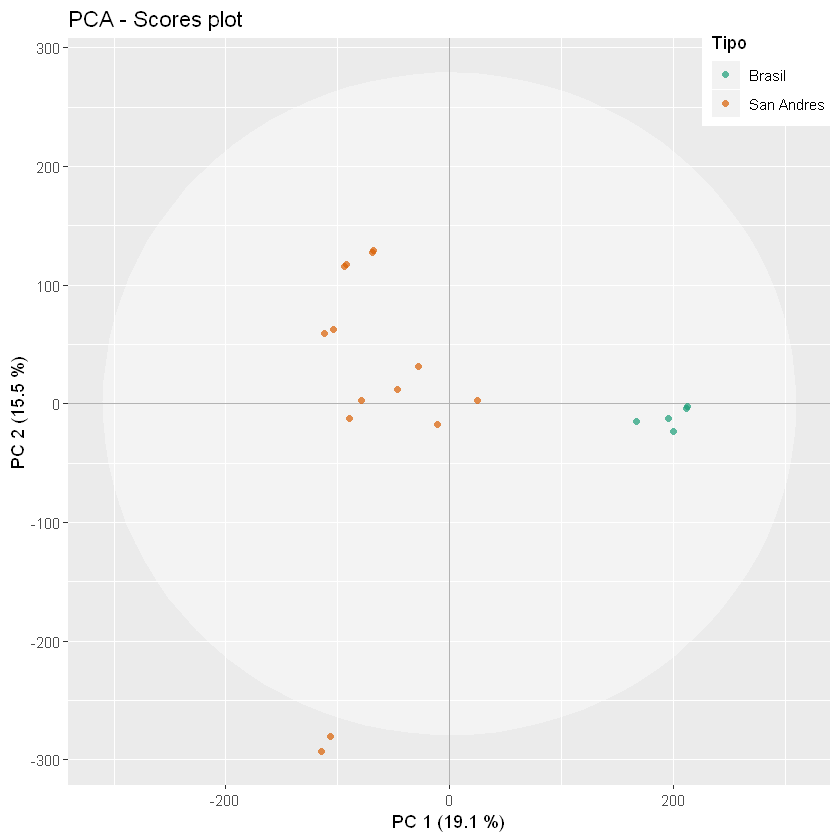

In [24]:
#PCA

pca.model.red=pca(X=red_propolis.pqn, pc=2, scale='UV', center=TRUE)

plotscores(model=pca.model.red, pc=c(1,2), an=list(Tipo=Metadata_red$Origen), title='PCA - Scores plot')



Warning message in if (grepl("stat|recon", type, ignore.case = T)) {:
"la condición tiene longitud > 1 y sólo el primer elemento será usado"

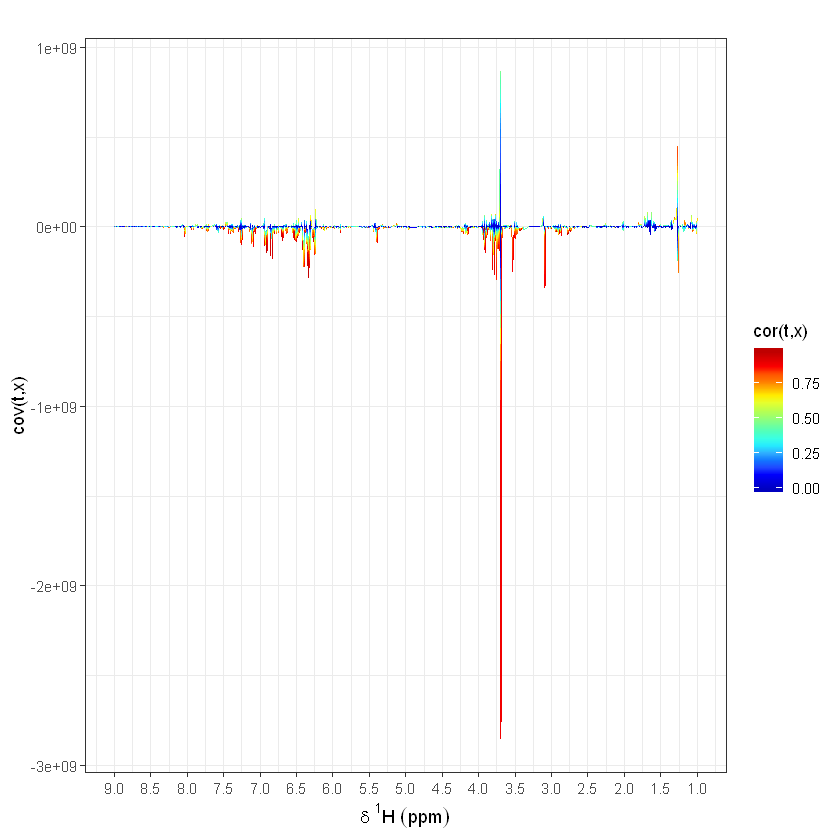

In [25]:
plotload(pca.model.red, red_propolis.pqn, ppm.ex, pc=2, shift=c(1,9))



Warning message in if (grepl("stat|recon", type, ignore.case = T)) {:
"la condición tiene longitud > 1 y sólo el primer elemento será usado"

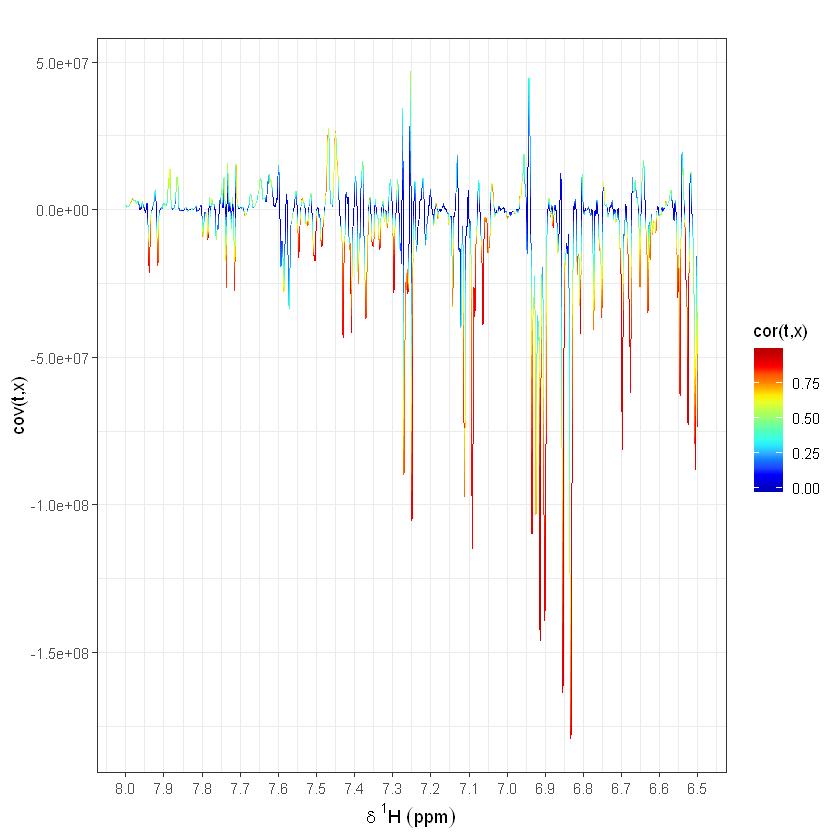

In [26]:
plotload(pca.model.red, red_propolis.pqn, ppm.ex, pc=2, shift=c(6.5,8))



In [27]:
#OPLS

Origen.red= as.character(Metadata_red$Zona)

red.prop.opls <- opls(red_propolis.pqn,Origen.red,predI=1,orthoI=NA)

#Training

red.prop.opls1 <- opls(red_propolis.pqn,Origen.red,predI=1,orthoI=NA, subset="odd")

#Predictions on the training subset

trainVi2 <- getSubsetVi(red.prop.opls1)
table(Origen.red[trainVi2], fitted(red.prop.opls1))

#Predictions on the test subset

table(Origen.red[-trainVi2],
      predict(red.prop.opls1, red_propolis.pqn[-trainVi2, ]))



OPLS-DA
19 samples x 83970 variables and 1 response
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum)  RMSEE pre ort pR2Y  pQ2
Total    0.264    0.995   0.909 0.0351   1   1 0.05 0.05


Warning message:
"'permI' set to 0 because train/test partition is selected"

OPLS-DA
10 samples x 83970 variables and 1 response
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum)  RMSEE RMSEP pre ort
Total    0.324    0.996     0.8 0.0324 0.118   1   1


     
      BRA BST
  BRA   3   0
  BST   0   7

     
      BRA BST
  BRA   2   0
  BST   0   7